# Stochastic volatility
This Notebook demos how to construct a stochastic volatility model and fit it to data. We will use a version of the precision model of G. Chacko and L. M. Viceira. `Dynamic consumption and portfolio choice with stochastic volatility in incomplete markets` given by, where we've replaced the mean reverting process with a random walk,
\begin{cases}
Y_t = \mu + e^{-V_t} W_t, \\
dV_t = \kappa (\gamma - V_{t}) + \sigma dU_t, \\
\end{cases}
where $\mu, \beta, \gamma \in \mathbb{R}$, and $\kappa, \sigma \in \mathbb{R}_+$.$\{U_t\}$ is a Brownian motion, wheras $\{W_t\}$ is assumed to follow a Student's t distribution with $\nu$ degrees of freedom. 

We begin with importing the necessary libraries for defining the model.

In [1]:
from pyfilter.timeseries import StateSpaceModel, models as m, AffineObservations, Parameter

Next, we define the governing dynamics, and set the default tensor to be CUDA

In [2]:
import torch

torch.set_default_tensor_type(torch.cuda.FloatTensor)


def go(vol, level):
    return level


def fo(vol, level):
    return vol.exp()

Next, we shall define our model. In order to do so, we must specify priors for the different parameters. Given their support, we assume that
\begin{cases}
    \mu, \gamma \sim \mathcal{N}(0, 1), \\
    \kappa \sim \mathcal{E}(10), \\
    \nu \sim \mathcal{E}(0.1), \\
    \sigma \sim \mathcal{E}(5). \\
\end{cases}
To do this, we need to import the necessary distributions.

In [3]:
from torch.distributions import Exponential, Normal, StudentT, Exponential

Next, we define the model in terms of code and get

In [4]:
logvol = m.OrnsteinUhlenbeck(Exponential(10.), Normal(0., 1.), Exponential(5.), ndim=1, dt=1.)
nu = Parameter(Exponential(0.1))
obs = AffineObservations((go, fo), (Normal(0., 1.),), StudentT(nu))

stockmodel = StateSpaceModel(logvol, obs)

And that defines the model. Next, we need a dataset to train on. We're just going to pick Apple Inc

In [5]:
import numpy as np
import pandas as pd

y = ...

We plot the data to get an idea of its volatility

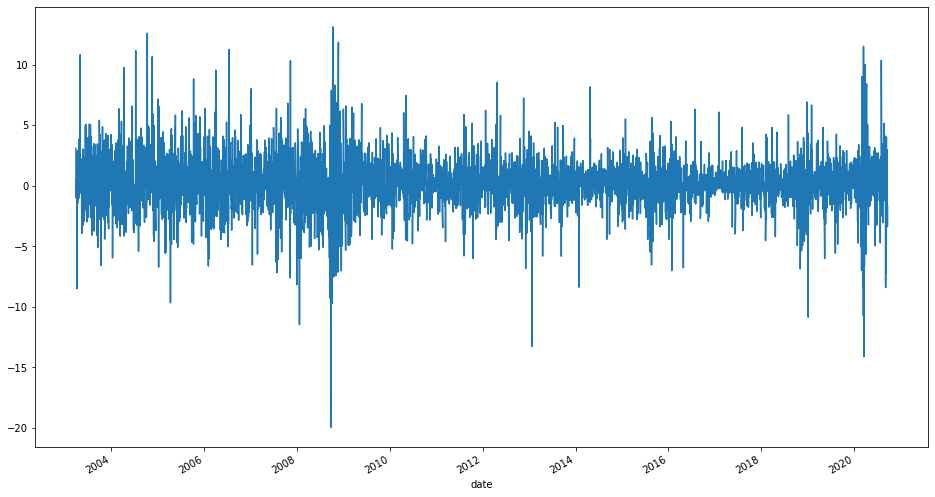

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))
y.plot(ax=ax)

In order to fit the model to the given data, we need an algorithm. We shall use the SMC2 by Nicolas Chopin et al. Furthermore, since we are using particle filters, we need to decide on which proposal to use - should we go with the Bootstrap or something more advanced? For this example, we will use the bootstrap as the problem's so low dimensional. Importing the relevant classes, we get

In [7]:
from pyfilter.inference.sequential import SMC2
from pyfilter.filters import APF

Let's now fit the model to the data

In [8]:
predictions = 5
training = torch.from_numpy(y.values[:-predictions]).float()

algs = list()
for i in range(2):
    filt = APF(stockmodel.copy(), 600)
    alg = SMC2(filt, 2000, threshold=0.5)

    state = alg.fit(training)
    
    algs.append((state, alg))

SMC2: 100%|████████████████████████████████████████████████████████████████████████| 4393/4393 [08:06<00:00,  9.02it/s]


Next, we plot the posterior distributions. The first corresponds to the standard deviation of the latent process. The last three ones correspond to the mean, exposure to variance and dof of the Student's t distribution.

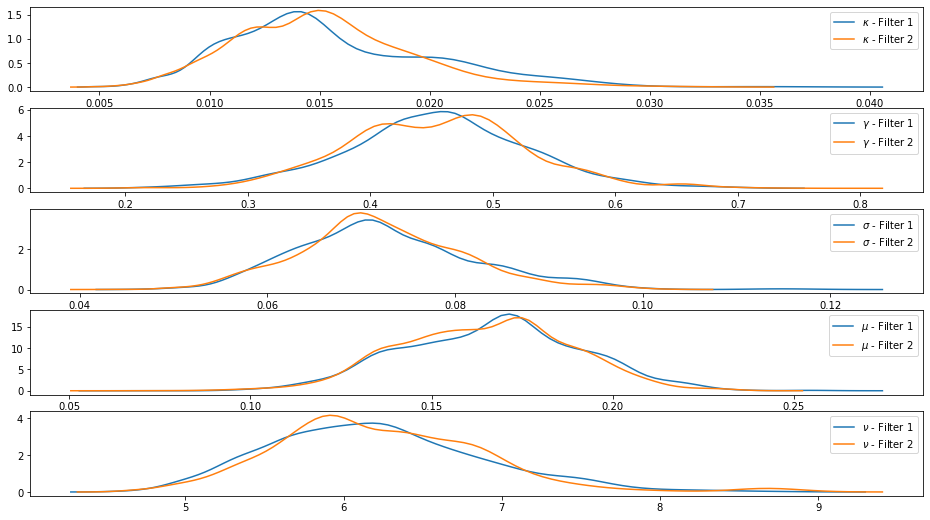

In [9]:
from pyfilter.utils import normalize

fig, ax = plt.subplots(len(alg.filter.ssm.theta_dists), figsize=(16, 9))

syms = '\\kappa, \\gamma, \\sigma, \\mu, \\nu'.split(',')

for r, (state, alg) in enumerate(algs):    
    w = normalize(state.w)
    
    for i, param in enumerate(alg.filter.ssm.theta_dists):    
        xrange, xvals = param.get_plottable(weights=w)

        ax[i].plot(xrange, xvals, label=f"${syms[i]}$ - Filter {r+1:d}")

        ax[i].legend()

Let's plot a crude estimate of the underlying volatility. I say crude here because we uniformly weight the trajectories.

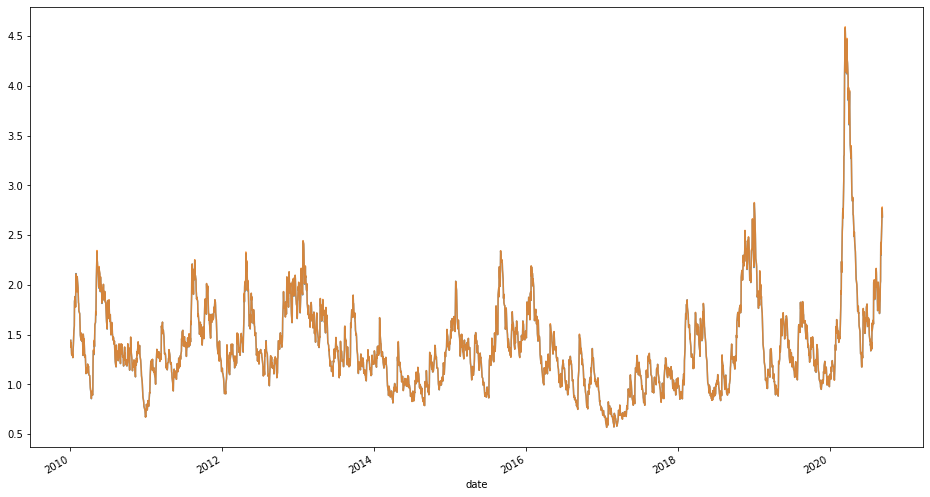

In [10]:
fig, ax = plt.subplots(figsize=(16, 9))
trunc = y.loc['2010-01-01':].iloc[:-predictions]

indx = y.index[:training.shape[0]]
for state, alg in algs:
    asdf = pd.DataFrame(alg.filter.result.filter_means.exp().cpu().numpy(), index=indx).mean(1)    
    asdf.loc[trunc.index].plot(alpha=0.75, ax=ax)

We can clearly see the volatility spike caused by the COVID breakout.

A plot over the ESS.

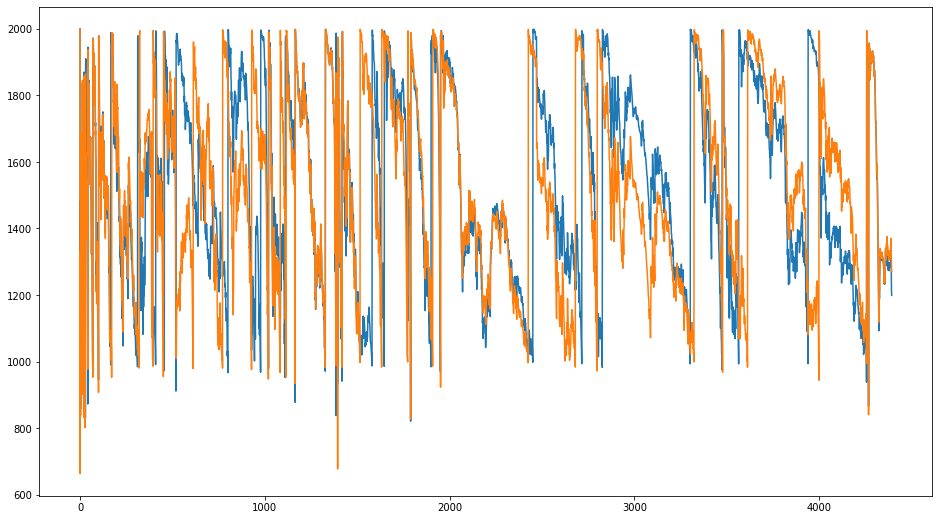

In [11]:
fig, ax = plt.subplots(figsize=(16, 9))
for state, alg in algs:
    ax.plot(alg.logged_ess.cpu().numpy())

Let's, finally, get an estimate of the return distribution 5 steps (days) into the future.

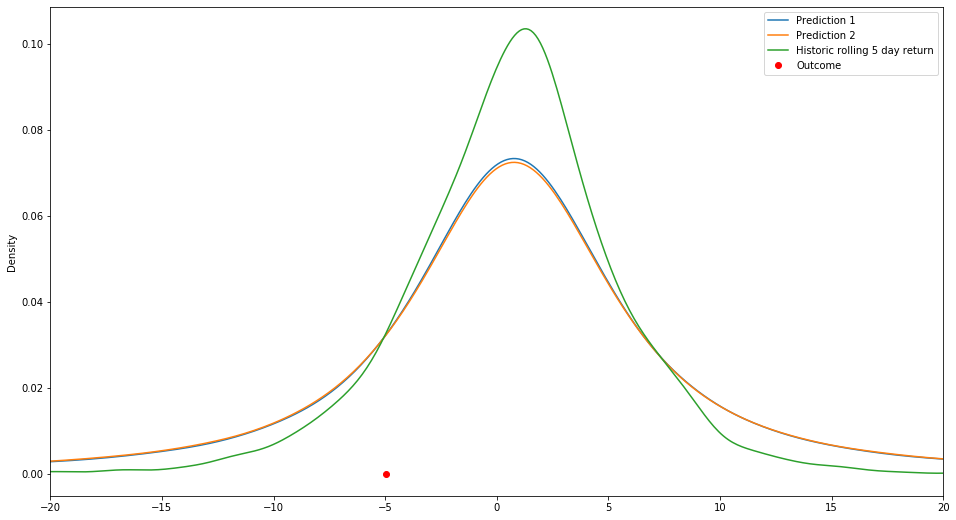

In [12]:
fig, ax = plt.subplots(figsize=(16, 9))

for i, (state, alg) in enumerate(algs):    
    _, yt = alg.predict(predictions, state, aggregate=False)  
            
    mask = yt.abs() > 100
    yt[mask] = 100 * yt[mask].sign()
    
    final = pd.Series(yt.sum(0).view(-1).cpu().numpy()).sort_values()
    final = final[int(0.05 * final.size):int(0.95 * final.size):50]

    final.plot.kde(ax=ax, label=f"Prediction {i + 1:d}")

y.iloc[:-predictions].rolling(predictions).sum().rename(f'Historic rolling {predictions:d} day return').plot.kde(ax=ax)
ax.set_xlim(-20, 20)
ax.plot(y.iloc[-predictions:].sum(), 0, 'ro', label='Outcome')
ax.legend()